In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDDE_args(ndde.arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, adj_data_size = 2,
                 model_dir = 'Bio_nDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2000., nt = 4000, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                 Xi = 0.1, R_m = 1., Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30, 
                 bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3
        elif bio_model_low_complex == 'NPZD': state_dim = 4
        elif bio_model_low_complex == 'NNPZD': state_dim = 5

        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot, is_tstart_zero = is_tstart_zero)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_low_complex)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the neural net architecture

In [5]:
class BioConstrainLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        
        super(BioConstrainLayer, self).__init__(**kwargs)
        
        self.gamma = tf.Variable(0.1, trainable=True, constraint = self.constraint)
        
    def constraint(self, gamma):
        
        out = tf.where(gamma <= 1., tf.where(gamma >= 0., gamma, 0.), 1.)
        
        return out
        
        
    def call(self, input):
        
        N_channel = self.gamma * input
        P_channel = - input
        Z_channel = (1. - self.gamma) * input
        
        output = tf.concat([N_channel, P_channel, Z_channel], axis=-1)
        
        return output

In [6]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, args, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)

        self.rnn_layer = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(7, activation='tanh', use_bias=True, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), 
                                                                        recurrent_initializer='random_normal'))
        
        self.x1 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim - 2, activation='linear',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.bio = BioConstrainLayer()
        
        self.args = args

    @tf.function
    def pass_layers(self, y_nn):
        
        for i in range(len(self.layers)):
            y_nn = self.layers[i](y_nn)
            
        return y_nn
    
    def call(self, y_nn):
        
        y_nn = self.pass_layers(y_nn)
        
        return y_nn

In [7]:
class DiscDDEFunc(tf.keras.Model):

    def __init__(self, main, rom_model, args, **kwargs):
        super(DiscDDEFunc, self).__init__(**kwargs)
        
        self.main = main
        self.rom_model = rom_model
        self.args = args
        
    def process_input(self, y, t ,d):     
        input = []
        for i in np.flip(np.arange(d[0])): # d is a list and d[0] contains the number of steps, while d[1] contains the time-step value to skip
            input.append(tf.expand_dims(y(t - i*d[1]), axis=0))

        input = tf.concat(input, axis=0)
        input = tf.transpose(input, perm=[1, 0] + [i for i in range(2, input.shape.rank)])
        
        return input

    def call_nn_part(self, input):
        dy_dt = self.main(input)
        return dy_dt
    
    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        y_nn = self.process_input(y, t, d)

        dy_dt = self.call_nn_part(y_nn) + self.rom_model(y, t, t_start)
        
        return dy_dt

### Define a custom plotting function

In [8]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(20, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=18)
        ax_x1.set_xlabel('t (Days)', fontsize=18)
        ax_x1.set_ylabel('Concentration', fontsize=18)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], '-r', label = 'N (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 0], '-.r', label = 'N (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], '--r', label = 'N (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 1], '-g', label = 'P (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 1], '-.g', label = 'P (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 1], '--g', label = 'P (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 2], '-b', label = 'Z (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 2], '-.b', label = 'Z (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 2], '--b', label = 'Z (Learned)')

        ax_x1.set_xlim(self.t[0], self.t[-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

        plt.show() 

### Initialize model related parameters

In [17]:
args = bio_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 4, epochs = 350, learning_rate = 0.05, 
                        decay_rate = 0.97, test_freq = 1, plot_freq = 1, d_max = 4., rnn_nmax = 6+1, rnn_dt = 0.75, 
                        model_dir = 'Bio_nDDE_testcase_v3/model_dir_case2', restart = 0, val_percentage = 10.,
                        T = 30., nt = 600, z = -25, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., 
                        Psi = 1.46, Xi = 0.1, R_m = 1.52, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, 
                        Omega = 0.041, T_bio = 30., bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', 
                        ode_alg_name = 'dopri5', nsteps = 5)

### Make a copy of the current script

In [18]:
testcase_dir = 'neuralClosureModels/testcases/Bio_Eqn'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Solve for the high complexity model

In [11]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

/home/abhinavgupta0110/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Higher complexity model done!


## Main part starts here

### Make objects and define learning-rate schedule

In [19]:
rom_model = bio.bio_eqn(app = args)
func_main = DDEFuncMain(args)
func = DiscDDEFunc(func_main, rom_model, args)

### Quick test to see how the true coefficients looks like

In [20]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
pred_y = ddeinttf(func, x0_low_complex, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],), alg_name = args.ode_alg_name, nsteps = args.nsteps)

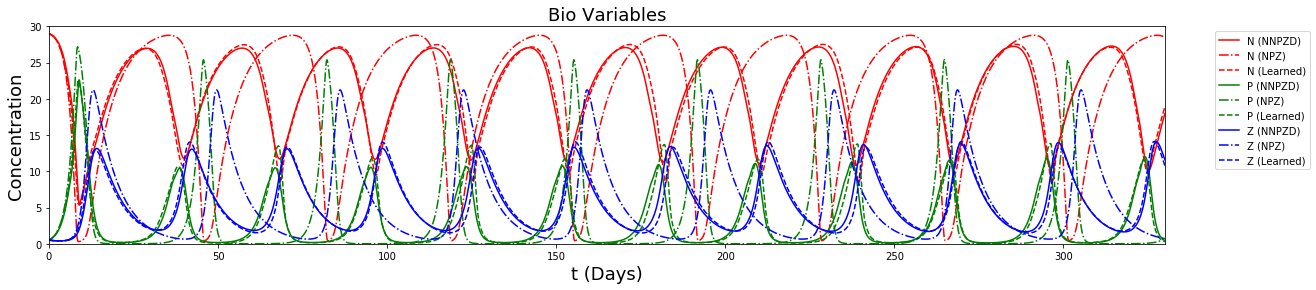

In [21]:
plot_obj = custom_plot(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_y)

### Print the network architecture

In [22]:
func_main.summary()

Model: "dde_func_main_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  multiple                  77        
_________________________________________________________________
dense_2 (Dense)              multiple                  56        
_________________________________________________________________
dense_3 (Dense)              multiple                  8         
_________________________________________________________________
bio_constrain_layer_1 (BioCo multiple                  1         
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [23]:
os.chdir(basedir)

data_dict = {'true_x_low_complex':true_x_low_complex, 'val_true_x_low_complex':val_true_x_low_complex,
             'x_low_complex':x_low_complex, 'val_x_low_complex':val_x_low_complex, 'pred_y': pred_y, 't': t, 'val_t': val_t}

with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDDE_C2_Exp3_predictions.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)